# Premium vs. basic users
Looking at differences between preimum and basic users.

## Import packages

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlalchemy as sal
import seaborn as sns
from plotting_utils import target_corr_plot
sns.set()

# For calculating standard error in mean
from scipy.stats import sem

import warnings
warnings.filterwarnings("ignore")

## Import data
Import the profile data from the SQL database

In [34]:
# Create SQL engine
engine = sal.create_engine('mysql://oskari:pw@localhost/chess_crawler', pool_recycle=3600, echo = False)

# Load data from the table 'profiles'
with engine.connect() as conn:
    profiles_df = pd.read_sql_table('profiles', conn)
    
# Remove duplicates of the same user
profiles_df.drop_duplicates(subset = 'id', inplace = True)

# Add log versions for numbers of games
n_games_columns = list(profiles_df.columns[[("n_games" in column) for column in profiles_df.columns]])
profiles_df = profiles_df.merge(np.log10(1+profiles_df[n_games_columns]).rename(columns = lambda x: x + "_log"), left_index = True, right_index = True)

display(profiles_df)

,row_id,id,username,jointime,status,puzzle_rush_best,blitz_rating,blitz_n_games,bullet_rating,bullet_n_games,...,daily_rating,daily_n_games,puzzle_rating,n_puzzles,t_puzzles,retrievetime,blitz_n_games_log,bullet_n_games_log,rapid_n_games_log,daily_n_games_log
0,1,41659808,flyingmo0se,1514199507,premium,32,744.0,443,NaN,0,...,400.0,1,2007,2138,161762,1638502802,2.647383,0.000000,2.789581,0.301030
1,2,101742786,russelljackson7,1607111534,premium,0,1035.0,1088,665.0,5,...,1552.0,41,2074,1023,86525,1638502805,3.037028,0.778151,2.576341,1.623249
3,4,144900567,hamikatsou,1623948572,basic,13,1032.0,1287,NaN,0,...,NaN,0,1089,58,2037,1638502820,3.109916,0.000000,2.928396,0.000000
4,5,39816298,cheikh68,1509117065,basic,19,1245.0,520,NaN,0,...,1544.0,294,2224,4628,382274,1638502831,2.716838,0.000000,2.583199,2.469822
5,6,110345778,anatolii_batiuk,1609974609,basic,8,1401.0,7031,1058.0,951,...,1006.0,3,552,30,780,1638502834,3.847079,2.978637,3.664924,0.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,3032,152604343,kurpiq,1630096314,premium,12,468.0,88,669.0,161,...,NaN,0,1090,325,13226,1640901866,1.949390,2.209515,2.397940,0.000000
3036,3037,162339689,shamanswisdom,1637694084,premium,0,NaN,0,NaN,0,...,NaN,0,708,26,282,1640902000,0.000000,0.000000,2.409933,0.000000
3037,3038,16050182,henrivk,1392374867,basic,23,1441.0,768,1323.0,206,...,1470.0,24,1236,49,1790,1640902008,2.885926,2.315970,3.478133,1.397940
3038,3039,91095830,danieldebarrenechea,1599936056,basic,0,NaN,0,NaN,0,...,NaN,0,1000,0,0,1640902018,0.000000,0.000000,3.032619,0.000000


## Basics
Summarizing some basic data about premium and basic users


In [46]:
basic_stats = profiles_df.groupby(by = 'status').agg(count = ('rapid_rating', len), mean_rapid = ('rapid_rating', np.mean), error = ('rapid_rating', sem))
basic_stats

,count,mean_rapid,error
status,,,
basic,2202,1610.321980,9.452584
closed,12,1844.750000,168.218568
closed:abuse,1,1259.000000,NaN
closed:fair_play_violations,63,2172.793651,52.609957
premium,451,1684.243902,21.798044
staff,1,2505.000000,NaN


## Rapid rating
Does getting a premium account make you better at chess? Testing here if preimum users have a higher rapid rating on average in my sample. This of course doesn't necessarily mean that getting premium makes you better - could just be that people who are better at chess and presumably spend more time on it find premium more worthwhile.

Start by making histogram of rapid ratings for basic and premium users:

Average rapid rating for basic users 1610.3+/-9.5
Average rapid rating for premium users 1684.2+/-21.8
Rating difference between basic and premium 73.9+/-23.8


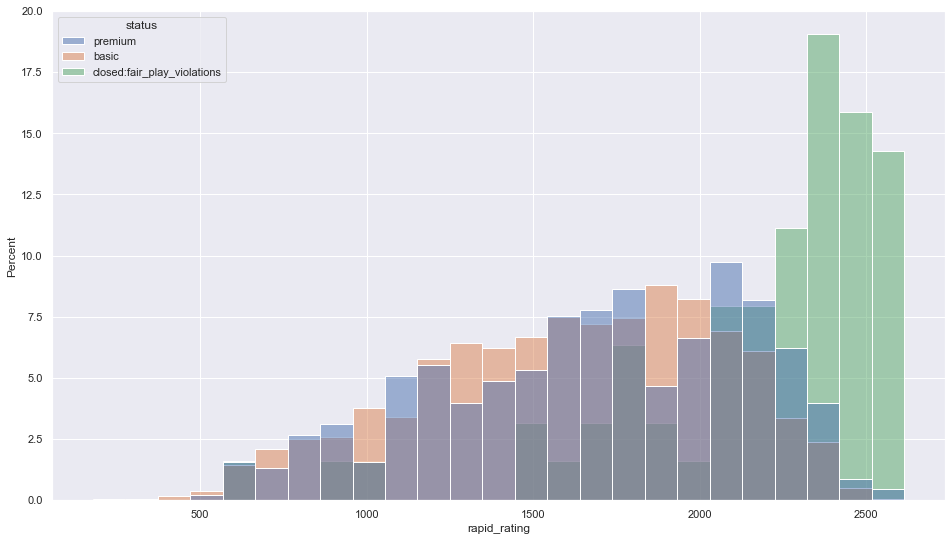

In [41]:
axes = sns.histplot(profiles_df[profiles_df.status.isin(['premium', 'basic', 'closed:fair_play_violations'])], x = 'rapid_rating', hue = 'status', stat = 'percent', common_norm = False)
axes.figure.set_size_inches((16,9))

# Also print the average ratings
## Basic users
basic_rapid = profiles_df[profiles_df.status == 'basic'].rapid_rating.mean()
basic_rapid_uc = sem(profiles_df[profiles_df.status == 'basic'].rapid_rating)
print(f"Average rapid rating for basic users {basic_rapid:.1f}+/-{basic_rapid_uc:.1f}")

## Premium users
premium_rapid = profiles_df[profiles_df.status == 'premium'].rapid_rating.mean()
premium_rapid_uc = sem(profiles_df[profiles_df.status == 'premium'].rapid_rating)
print(f"Average rapid rating for premium users {premium_rapid:.1f}+/-{premium_rapid_uc:.1f}")

# Calculate difference in ratings
rating_difference = premium_rapid - basic_rapid
rating_difference_uc = np.sqrt(premium_rapid_uc**2 + basic_rapid_uc**2)
print(f"Rating difference between basic and premium {rating_difference:.1f}+/-{rating_difference_uc:.1f}")

There isn't a very noticeable difference between the premium and basic users in the histograms, although the mean is somewhat higher for premium users as aI would have expected. By far the highest average rating is for accounts that have been closed for cheating.

Now let's do some formal hypothesis testing. My hypothesis is that premium users are on average more highly rated than basic users. The corresponding null hypothesis is then that the average rating of premium users is the same or lower than that of basic users. The data is not very close to a normal distribution, so to test the hypothesis I will use a premutation test: 
- Merge the data for basic and premium users
- Randomly draw resamples of the corresponding sizes for basic and premium users
- Calculate the mean rapid ratings for the new "basic" and "premium" user distributions (these distributions are drawn from the merged data), and calculate the difference
- Repeat this R times to get a distribution of the rating differences
- Calculate probability of observed difference in the real data being due to chance using the obtained distribution


In [72]:
# Get the ratings of basic and premium players
merged_ratings = profiles_df[profiles_df.status.isin(['premium', 'basic'])].rapid_rating.reset_index(drop = True)

# Figure out the numbers of basic and premium users so can resample correct number
n_basic = basic_stats.loc['basic', 'count']
n_premium = basic_stats.loc['premium', 'count']

# Define number of trials for permutation test
R = 2000

# Define a function that performs the resampling and calculates the difference in the mean
def resample_func(data, n1: int, n2: int) -> float:
    """
    Resamples data by choosing n1 items for distribution 1 and n2 for distribution 2
    """
    # Get indices for resampling of data
    idx1 = set(np.random.choice(range(len(data)), size = n1, replace = False))
    idx2 = set(range(len(data))) - idx1
    
    return data.loc[idx1].mean() - data.loc[idx2].mean()

# Loop over R resamplings and calculate diffence in mean
differences = np.zeros(R)
for i in range(R):
    differences[i] = resample_func(merged_ratings, n_premium, n_basic)

Now plot the distribution of differences:

p value: 0.001


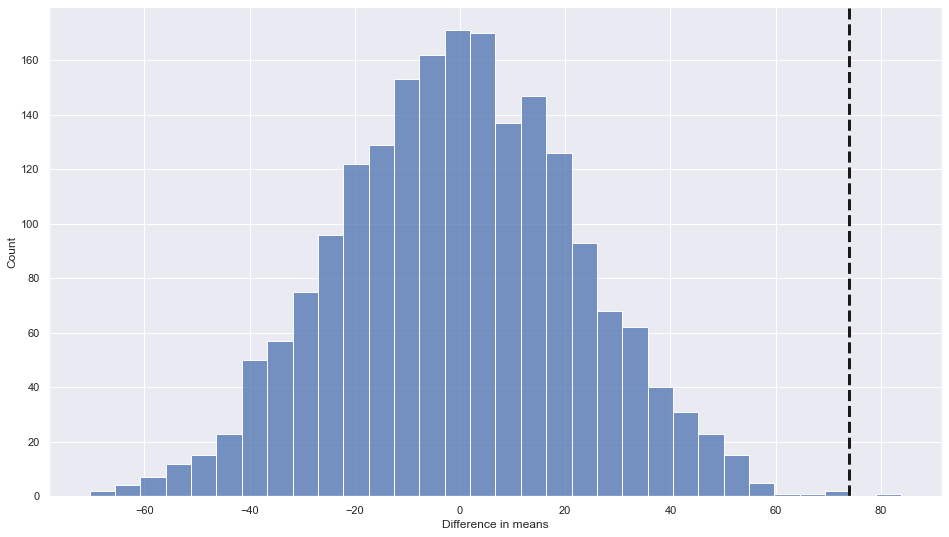

In [73]:
axes = sns.histplot(differences)
axes.figure.set_size_inches((16,9))
axes.axes.set_xlabel("Difference in means")
axes.axes.axvline(rating_difference, ls = '--', c = 'k', linewidth = 3)

# Print the probability of the resampled differences being above the observed difference
p_value = np.mean(rating_difference < differences)
print(f"p value: {p_value:.3f}")

There are very few cases where the difference between the resampled distributions exceeds the observed difference. Therefore we can reject the null hypothesis and be quite confident in saying that the premium users have a higher average rating.